# Preprocessing

## Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath('../modules'))
from utils import plot_pca, plot_umap, quick_stats
from preproc import PhishingDatasetPreproc, feature_selection_pipeline

In [4]:
prep = PhishingDatasetPreproc()

## Basic operations

In [5]:
dataset, X, y = prep.basic_operations()

In [4]:
quick_stats(dataset)

,count,mean,std,min,25%,50%,75%,max,-1,0,1
having_IP_Address,11055,0,1,-1,-1,1,1,1,3793,0,7262
URL_Length,11055,-1,1,-1,-1,-1,-1,1,8960,135,1960
Shortining_Service,11055,1,1,-1,1,1,1,1,1444,0,9611
having_At_Symbol,11055,1,1,-1,1,1,1,1,1655,0,9400
double_slash_redirecting,11055,1,1,-1,1,1,1,1,1429,0,9626
Prefix_Suffix,11055,-1,1,-1,-1,-1,-1,1,9590,0,1465
having_Sub_Domain,11055,0,1,-1,-1,0,1,1,3363,3622,4070
SSLfinal_State,11055,0,1,-1,-1,1,1,1,3557,1167,6331
Domain_registeration_length,11055,-0,1,-1,-1,-1,1,1,7389,0,3666
Favicon,11055,1,1,-1,1,1,1,1,2053,0,9002


## Quick visualization in 2D (PCA and UMAP)

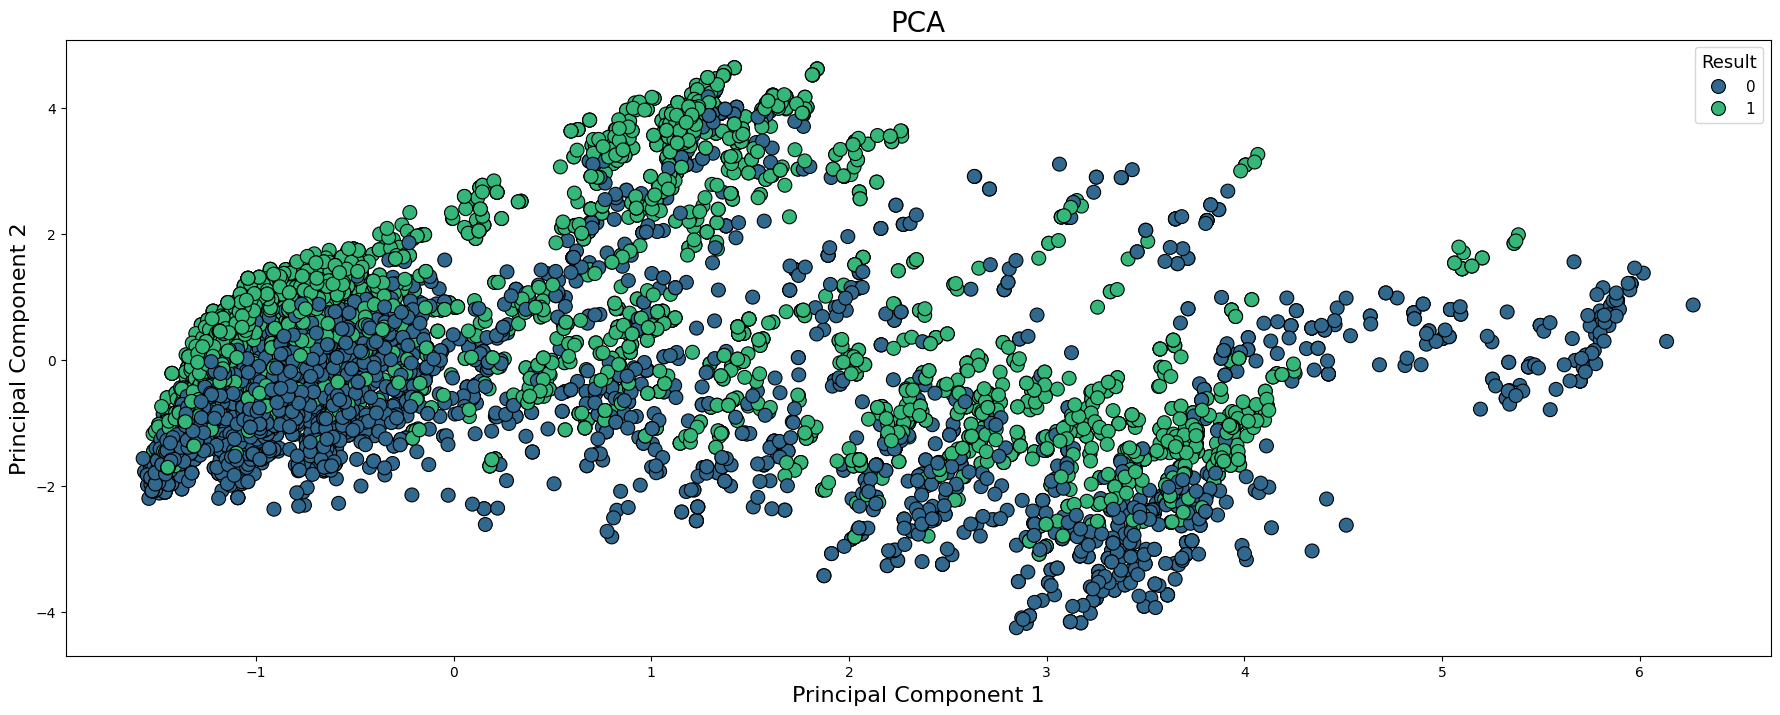

In [4]:
plot_pca(dataset)

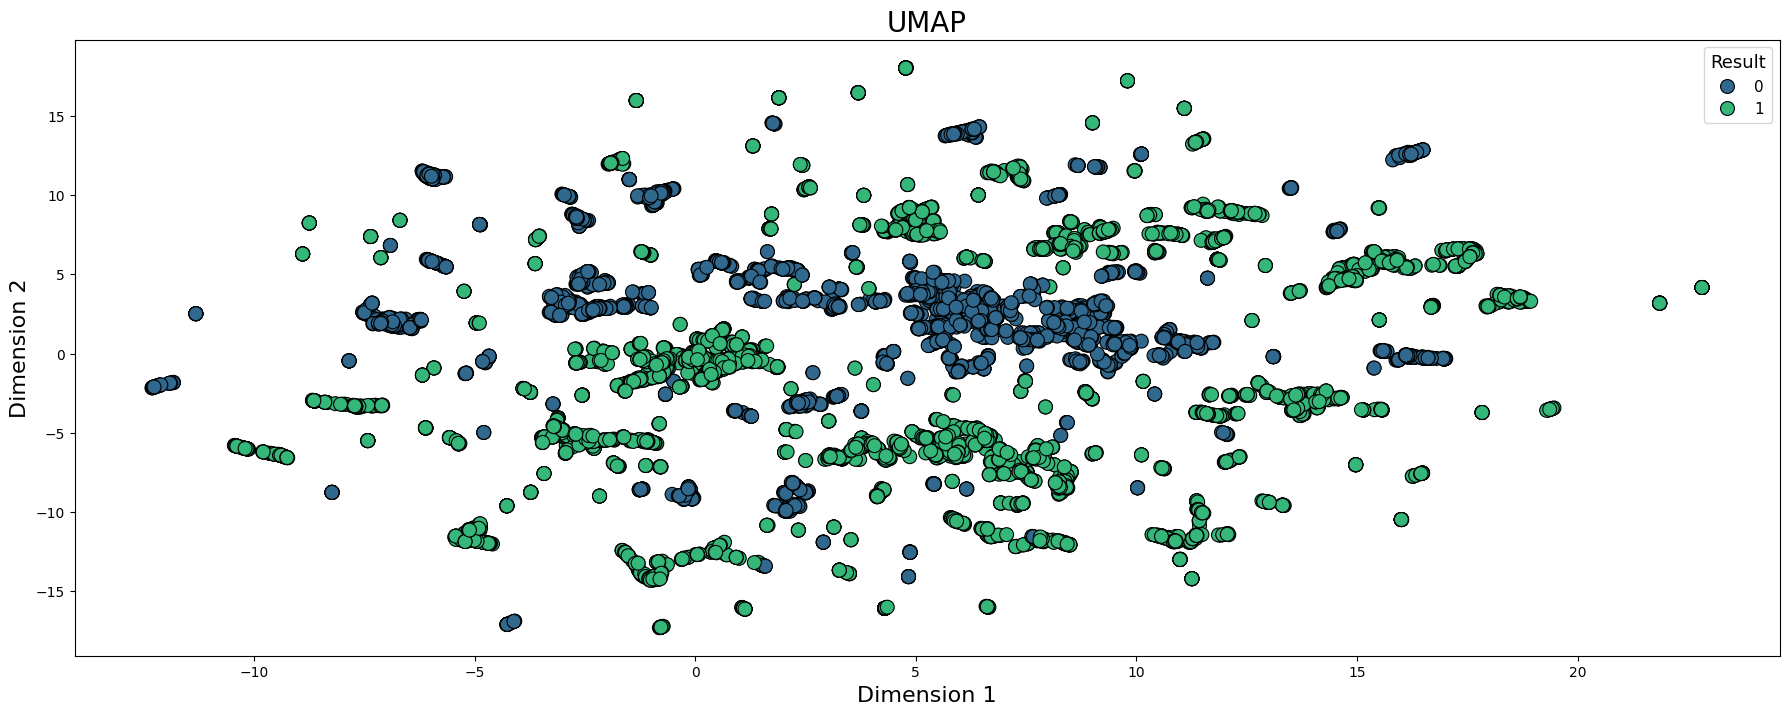

In [5]:
plot_umap(dataset)

## Splitting the data

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Feature selection

Different feature selection approaches will be tested:

- Tree-based feature selection
- PCA
- Univariate feature selection
- L1-based feature selection

In order to build a more robust preprocessing pipeline, these techniques will be tested using a randomized search cross-validation.

The scikit-learn user guide provides excellent documentation for these methods, as well as how to pipeline them with ML models:

- [Scikit-learn feature selection user guide](https://scikit-learn.org/stable/modules/feature_selection.html#removing-features-with-low-variance);

- [Scikit-learn tutorial on pipelining PCA as a feature selection technique with a logistic regression classifier](https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html).

The `feature_selection_pipeline` function was created to simplify this process. 

The `eval_feature_selectors` function was designed to simplify the process of evaluating all of these feature selection methods accross all classifiers.

These functions are available on the module `preproc`, but are also included in this notebook along with an example usage.

### Implemented functions

In [6]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn import datasets

def feature_selection_pipeline(model, param_grid=dict, fs_method=str, X=pd.DataFrame, y=pd.Series, n_iter=10):
    '''
    Creates and runs a pipeline with a specified feature selection method and model.
    
    model: model to use in the pipeline (e.g., LogisticRegression())
    param_grid: dictionary with hyperparameters for both the feature selection and model
    fs_method: str specifying feature selection ("tree", "pca", "univariate", "l1")
    n_iter: number of random samples for RandomizedSearchCV
    '''
    fs_methods = {
        "tree": SelectFromModel(estimator=RandomForestClassifier(n_estimators=100)),
        "pca": PCA(),
        "univariate": SelectKBest(f_classif),
        "l1": SelectFromModel(estimator=Lasso(alpha=0.1))
    }
    
    if fs_method in fs_methods.keys():
        print(fs_method)
        feature_selector = fs_methods[fs_method]
        print(feature_selector)
    else:
        raise ValueError("Unknown feature selection method")
        
    pipeline = Pipeline([
        ("selector", feature_selector), 
        ("model", model)
    ])
    
    search = RandomizedSearchCV(pipeline, param_grid, n_iter=n_iter, n_jobs=2, random_state=42, verbose=1)

    search.fit(X,y)
    
    # Return best score and params
    return search.best_score_, search.best_params_

def eval_feature_selectors(model, param_grids, X, y, n_iter=10):
    '''
    Evaluates multiple feature selection methods and returns a DataFrame with the results.
    
    model: model to use in the pipeline (e.g., LogisticRegression())
    param_grids: list of dictionaries with hyperparameters for each feature selection and model
    X: DataFrame with features
    y: Series or array with target variable
    n_iter: number of random samples for RandomizedSearchCV
    '''
    selectors = ["tree", "pca", "univariate", "l1"]
    results = []

    for selector, param_grid in zip(selectors, param_grids):
        best_score, best_params = feature_selection_pipeline(
            model=model,
            param_grid=param_grid,
            fs_method=selector,
            X=X,
            y=y,
            n_iter=n_iter
        )
        results.append({"selector_name": selector, "best_cv_score": best_score, "best_params": best_params})

    return pd.DataFrame(results)

### Example usage

In [8]:
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings('ignore')

`feature_selection_pipeline` standalone usage:

In [13]:
model = RandomForestClassifier()

param_grid = {
    "selector__n_components": [5, 15, 30, 45, 60],
    'model__criterion': ['gini', 'entropy', 'log_loss']
}

fs_method = 'pca'

best_score, best_params = feature_selection_pipeline(model, param_grid, fs_method, X, y)

print("Best CV score:", best_score)
print("Best parameters:", best_params)

pca
PCA()
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best CV score: 0.9605608322026231
Best parameters: {'selector__n_components': 30, 'model__criterion': 'gini'}


`eval_feature_selectors` usage:

In [ ]:
param_grids = [
    {"selector__max_features": [5, 10, 15], "model__max_depth": [3, 5, None]},      # Tree-based
    {"selector__n_components": [5, 15, 30, 45, 60], "model__max_depth": [3, 5, None]},  # PCA
    {"selector__k": [5, 10, 15], "model__max_depth": [3, 5, None]},               # Univariate
    {"selector__max_features": [5, 10, 15], "model__max_depth": [3, 5, None]}     # L1-based
]

selector_eval_results = eval_feature_selectors(model, param_grids, X, y, n_iter=10)
selector_eval_results.to_csv('../outputs/selector_eval_results.csv')

tree
SelectFromModel(estimator=RandomForestClassifier())
Fitting 5 folds for each of 9 candidates, totalling 45 fits
pca
PCA()
Fitting 5 folds for each of 10 candidates, totalling 50 fits
univariate
SelectKBest()
Fitting 5 folds for each of 9 candidates, totalling 45 fits
l1
SelectFromModel(estimator=Lasso(alpha=0.1))
Fitting 5 folds for each of 9 candidates, totalling 45 fits


To import from the `preproc` module, do:

In [12]:
from preproc import feature_selection_pipeline, eval_feature_selectors